<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Aligning Pyleoclim Series



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pyleoclim as pyleo
import numpy as np
pyleo.set_style('web')
pyleo.__version__

'1.0.0b0'

## Loading and visualizing $\delta D$ series

We use `pandas` to load the data directly from the NCEI/NOAA repository, bypassing a download. However, if you want to keep a local copy of this file for posterity or to work offline, the command would work just the same (just specify a local path, like `'../data/edc3deuttemp2007.txt'`. 

In [2]:
dDdf = pd.read_csv('../data/edc3deuttemp2007.csv')
dDdf.head()

,Age,Deuterium,Temperature
0,38.37379,-390.9,0.88
1,46.81203,-385.1,1.84
2,55.05624,-377.8,3.04
3,64.41511,-394.1,0.35
4,73.15077,-398.7,-0.42


In [3]:
dDts = pyleo.Series(time=dDdf['Age']/1000,value= dDdf['Deuterium'],time_name='Age',time_unit='kyr BP',value_name = r'$\delta D$',value_unit=u'\u2030',label=r'EPICA Dome C $\delta D$')

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='$\\delta D$ [‰]'>)

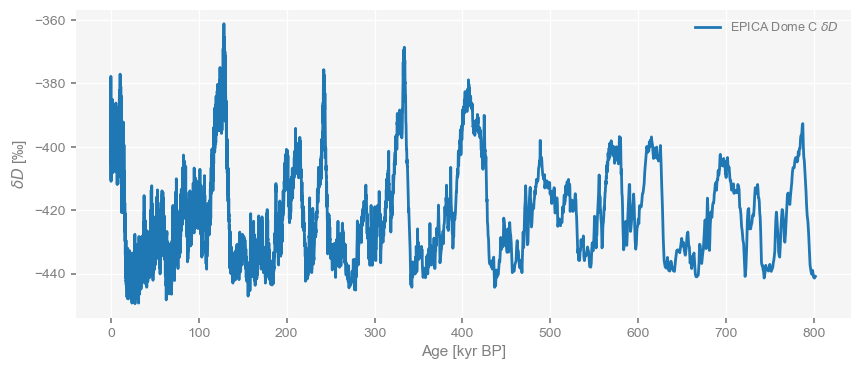

In [5]:
dDts.plot()

Now let us load the $CO_2$ composite from this and other neighboring sites around Antarctica:

In [5]:
url = 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt'
co2df = pd.read_csv(url,skiprows=137,sep='\t')
co2df.head()

,age_gas_calBP,co2_ppm,co2_1s_ppm
0,-51.03,368.02,0.06
1,-48.00,361.78,0.37
2,-46.28,359.65,0.10
3,-44.41,357.11,0.16
4,-43.08,353.95,0.04


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='$CO_2$ [ppm]'>)

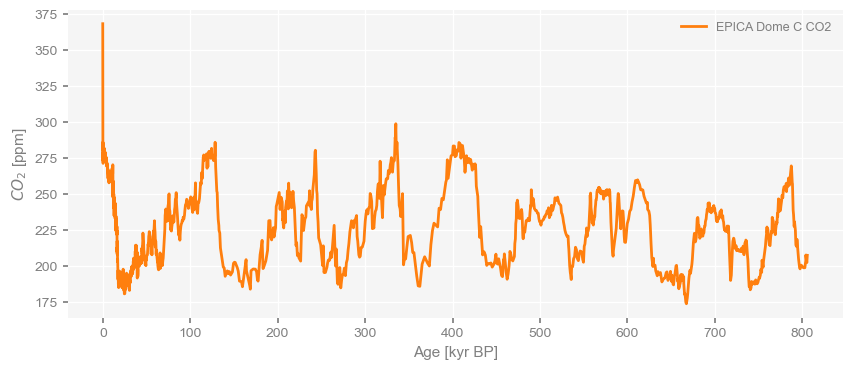

In [14]:
co2ts = pyleo.Series(time=co2df['age_gas_calBP']/1000, value= co2df['co2_ppm'],
                     time_name='Age',time_unit='kyr BP',value_name = r'$CO_2$',value_unit='ppm',
                     label='EPICA Dome C CO2')
co2ts.plot(color='C1')

We see very similar Ice Ages as in the deuterium data and of course a precipitous rise since the Industrial Revolution.  To plot the two series side by side, we can put them into a `MultipleSeries` object and use the default plot function:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [kyr BP]', ylabel='value'>)

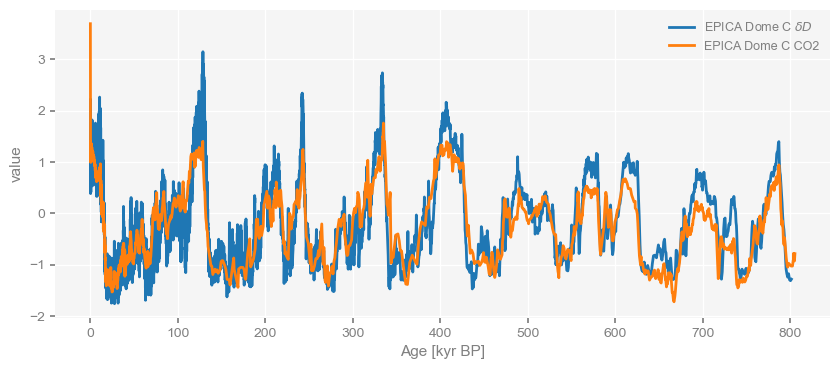

In [8]:
ms = pyleo.MultipleSeries([dDts,co2ts])
ms.standardize().plot()

What is not immediately apparent from this picture is that both records have different resolutions, as can be glean from a cursory inspection of the distribution of age increments:

Text(0.5, 0.98, 'Distribution of age increments')

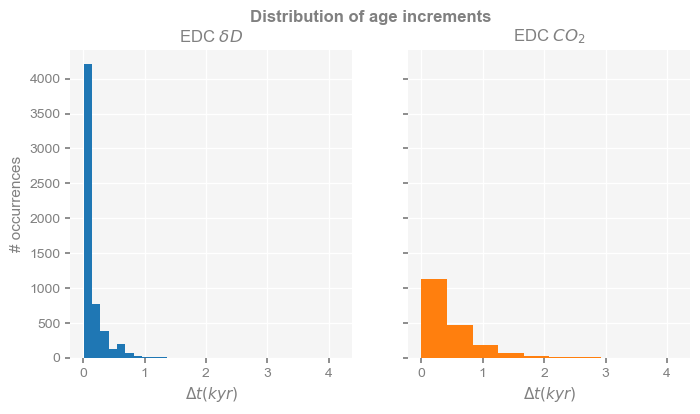

In [13]:
fig, ax = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
axs = ax.flatten()
axs[0].hist(np.diff(dDts.time))
axs[0].set_xlabel(r'$\Delta t (kyr)$')
axs[0].set_ylabel('# occurrences')
axs[0].set_title('EDC ' + dDts.value_name)
axs[1].hist(np.diff(co2ts.time), color='C1')
axs[1].set_xlabel(r'$\Delta t (kyr)$')
axs[1].set_title('EDC ' + co2ts.value_name)

plt.suptitle('Distribution of age increments',weight='bold')

The data are unevenly spaced, which is a challenge because most timeseries analysis methods (e.g. correlation analysis) implicitly assume that data are evenly spaced. Further, they assume that all series being correlated share the same time axis.  This would fail on both counts here, and we therefore need to put the two Series on a common axis.

This can be done with [common_time()](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#pyleoclim.core.multipleseries.MultipleSeries.common_time), which does 2 things: 
1. picks a time axis with increments chosen according to [increments()](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.tsutils.increments). By default, this picks the median spacing of both series.
1. applies one of three possible methods to aggregate the data to the new time: linear interpolation (default), binning, and a Gaussian kernel. 

Applying the default, we get:

Text(0.5, 0.98, 'Distribution of age increments')

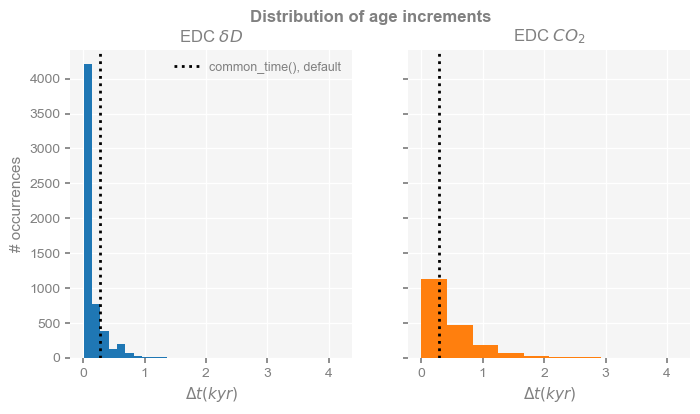

In [25]:
msc1 = ms.common_time()
inc1 = np.diff(msc1.series_list[0].time)[0] # grab increment
#               
fig, ax = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
axs = ax.flatten()
axs[0].hist(np.diff(dDts.time))
axs[0].set_xlabel(r'$\Delta t (kyr)$')
axs[0].set_ylabel('# occurrences')
axs[0].set_title('EDC ' + dDts.value_name)
axs[0].axvline(x=inc1, label='common_time(), default', ls = ':', color='k')
axs[0].legend()
axs[1].hist(np.diff(co2ts.time), color='C1')
axs[1].set_xlabel(r'$\Delta t (kyr)$')
axs[1].set_title('EDC ' + co2ts.value_name)
axs[1].axvline(x=inc1, label='common_time(), default', ls = ':', color='k')
plt.suptitle('Distribution of age increments',weight='bold')

So far, none of this has used pandas in any way, and checks were done under the hood re: units, direction of time flow, etc, that could now be automated with exponent, datum and direction parameters.   

Also, now that Series objects have a datetime index property, can [align](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.align.html) or something similar be leveraged to put the constituent Series objects of a MultipleSeries object on a common datetime index? 
`Align` has some desirable features, but it offers fairly primitive ways of filling the holes (method{‘backfill’, ‘bfill’, ‘pad’, ‘ffill’, None}, default None), so we would want the ability to apply `interp()`, `bin()` and `gkernel()` as methods. Is "dispatching" a way to do that? 

I hope the questions makes sense. 